# Image Captioning

**Author:** [A_K_Nain](https://twitter.com/A_K_Nain)<br>
**Date created:** 2021/05/29<br>
**Last modified:** 2021/10/31<br>
**Description:** Implement an image captioning model using a CNN and a Transformer.

## Setup

In [26]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import re
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import layers
from keras.applications import efficientnet
from keras.layers import TextVectorization

keras.utils.set_random_seed(111)

## Download the dataset

We will be using the Flickr8K dataset for this tutorial. This dataset comprises over
8,000 images, that are each paired with five different captions.

In [27]:
# Desired image dimensions
IMAGE_SIZE = (299, 299)

# Vocabulary size
VOCAB_SIZE = 10000

# Fixed length allowed for any sequence
SEQ_LENGTH = 25

# Dimension for the image embeddings and token embeddings
EMBED_DIM = 512

# Per-layer units in the feed-forward network
FF_DIM = 512

# Other training parameters
BATCH_SIZE = 64
EPOCHS = 30
AUTOTUNE = tf.data.AUTOTUNE

## Preparing the dataset

In [28]:
import json
import os
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.xception import preprocess_input
from fdl_project.classes.dataset_loader import DatasetLoader

# Load the dataset
dataset = DatasetLoader().load_data(folder_name=os.path.join(os.getcwd(), "coco"))

Loading data..
Data loaded succesfully!
Loading data..
Data loaded succesfully!


In [29]:
def load_captions_data(dataset):
    text_annotations = []

    # Create a mapping from image_id to file_name
    image_id_to_file_name = {image["id"]: image["file_name"] for image in dataset["images"]}

    # Create a mapping from image_id to captions
    image_id_to_captions = {}
    for annotation in dataset["annotations"]:
        image_id = annotation["image_id"]
        caption = "<start> " + annotation["caption"] + " <end>"

        if image_id not in image_id_to_captions:
            image_id_to_captions[image_id] = []

        image_id_to_captions[image_id].append(caption)
        text_annotations.append(caption)

    # Create a combined dictionary with image file names and their corresponding captions
    file_name_to_captions = {
        image_id_to_file_name[image_id]: captions
        for image_id, captions in image_id_to_captions.items()
    }

    return file_name_to_captions, text_annotations


def train_val_split(caption_data, train_size=0.8, shuffle=True):
    """Split the captioning dataset into train and validation sets.

    Args:
        caption_data (dict): Dictionary containing the mapped caption data
        train_size (float): Fraction of all the full dataset to use as training data
        shuffle (bool): Whether to shuffle the dataset before splitting

    Returns:
        Traning and validation datasets as two separated dicts
    """

    # 1. Get the list of all image names
    all_images = list(caption_data.keys())

    # 2. Shuffle if necessary
    if shuffle:
        np.random.shuffle(all_images)

    # 3. Split into training and validation sets
    train_size = int(len(caption_data) * train_size)

    training_data = {
        img_name: caption_data[img_name] for img_name in all_images[:train_size]
    }
    validation_data = {
        img_name: caption_data[img_name] for img_name in all_images[train_size:]
    }

    # 4. Return the splits
    return training_data, validation_data

# Load the dataset
captions_mapping, text_data = load_captions_data(dataset)

# Split the dataset into training and validation sets
train_data, valid_data = train_val_split(captions_mapping)
print("Number of training samples: ", len(train_data))
print("Number of validation samples: ", len(valid_data))

Number of training samples:  66226
Number of validation samples:  16557


In [30]:
captions_mapping

{'COCO_train2014_000000318556.jpg': ['<start> A very clean and well decorated empty bathroom <end>',
  '<start> A blue and white bathroom with butterfly themed wall tiles. <end>',
  '<start> A bathroom with a border of butterflies and blue paint on the walls above it. <end>',
  '<start> An angled view of a beautifully decorated bathroom. <end>',
  '<start> A clock that blends in with the wall hangs in a bathroom.  <end>'],
 'COCO_train2014_000000116100.jpg': ['<start> A panoramic view of a kitchen and all of its appliances. <end>',
  '<start> A panoramic photo of a kitchen and dining room <end>',
  '<start> A wide angle view of the kitchen work area <end>',
  '<start> multiple photos of a brown and white kitchen.  <end>',
  '<start> A kitchen that has a checkered patterned floor and white cabinets. <end>'],
 'COCO_train2014_000000379340.jpg': ['<start> A graffiti-ed stop sign across the street from a red car  <end>',
  '<start> A vandalized stop sign and a red beetle on the road <end>'

## Vectorizing the text data

We'll use the `TextVectorization` layer to vectorize the text data,
that is to say, to turn the
original strings into integer sequences where each integer represents the index of
a word in a vocabulary. We will use a custom string standardization scheme
(strip punctuation characters except `<` and `>`) and the default
splitting scheme (split on whitespace).

In [31]:

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")


strip_chars = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"
strip_chars = strip_chars.replace("<", "")
strip_chars = strip_chars.replace(">", "")

vectorization = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=SEQ_LENGTH,
    standardize=custom_standardization,
)
vectorization.adapt(text_data)

# Data augmentation for image data
image_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
        layers.RandomContrast(0.3),
    ]
)


## Building a `tf.data.Dataset` pipeline for training

We will generate pairs of images and corresponding captions using a `tf.data.Dataset` object.
The pipeline consists of two steps:

1. Read the image from the disk
2. Tokenize all the five captions corresponding to the image

In [32]:
# append coco/train2014/ to all the keys of the dictionary

train_data = {
    os.path.join("coco/train2014/", key): value for key, value in train_data.items()
}

In [33]:
train_data["coco/train2014/COCO_train2014_000000254362.jpg"]

['<start> Three picture frames of ducks swimming in water. <end>',
 '<start> Multiple shots of birds swimming on top of the water. <end>',
 '<start> A group of ducks on a calm body of water. <end>',
 '<start> A set of three photos showing a group of ducks moving across water. <end>',
 '<start> Three film clips of a pond of ducks.  <end>',
 '<start> Three panels of ducks swimming on a wide pond. <end>']

In [34]:
# check in train_data if there are more than 5 values
# remove the 6th value and keep the first 5 values

for key, value in train_data.items():
    if len(value) > 5:
        # print(key, len(value))
        train_data[key] = value[:5]

In [35]:
def decode_and_resize(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img


def process_input(img_path, captions):
    print("PROCESS_INPUT: LEN DATASET", len(dataset))
    return decode_and_resize(img_path), vectorization(captions)


def make_dataset(images, captions):
    dataset = tf.data.Dataset.from_tensor_slices((images, tf.ragged.constant((captions))))
    dataset = dataset.shuffle(BATCH_SIZE * 8)
    dataset = dataset.map(process_input, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

    return dataset


# Pass the list of images and the list of corresponding captions
train_dataset = make_dataset(list(train_data.keys()), list(train_data.values()))

valid_dataset = make_dataset(list(valid_data.keys()), list(valid_data.values()))

PROCESS_INPUT: LEN DATASET 4
PROCESS_INPUT: LEN DATASET 4


## Building the model

Our image captioning architecture consists of three models:

1. A CNN: used to extract the image features
2. A TransformerEncoder: The extracted image features are then passed to a Transformer
                    based encoder that generates a new representation of the inputs
3. A TransformerDecoder: This model takes the encoder output and the text data
                    (sequences) as inputs and tries to learn to generate the caption.

In [36]:
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    Input,
    Embedding,
    LSTM,
    Add,
)
from tensorflow.keras.models import Model


def get_cnn_model(input_shape=(*IMAGE_SIZE, 3)):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation="relu")(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation="relu")(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation="relu")(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(256, (3, 3), activation="relu")(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(256, activation="relu")(x)
    model = Model(inputs, x)
    return model


# def get_cnn_model():
#     base_model = efficientnet.EfficientNetB0(
#         input_shape=(*IMAGE_SIZE, 3),
#         include_top=False,
#         weights="imagenet",
#     )
#     # We freeze our feature extractor
#     base_model.trainable = False
#     base_model_out = base_model.output
#     base_model_out = layers.Reshape((-1, base_model_out.shape[-1]))(base_model_out)
#     cnn_model = keras.models.Model(base_model.input, base_model_out)
#     return cnn_model


class ImageCaptioningModel(keras.Model):
    def __init__(
        self,
        cnn_model,
        encoder,
        decoder,
        num_captions_per_image=5,
        image_aug=None,
    ):
        super().__init__()
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.acc_tracker = keras.metrics.Mean(name="accuracy")
        self.num_captions_per_image = num_captions_per_image
        self.image_aug = image_aug

    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)

    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)

    def _compute_caption_loss_and_acc(self, img_embed, batch_seq, training=True):
        encoder_out = self.encoder(img_embed, training=training)
        batch_seq_inp = batch_seq[:, :-1]
        batch_seq_true = batch_seq[:, 1:]
        mask = tf.math.not_equal(batch_seq_true, 0)
        batch_seq_pred = self.decoder(
            batch_seq_inp, encoder_out, training=training, mask=mask
        )
        loss = self.calculate_loss(batch_seq_true, batch_seq_pred, mask)
        acc = self.calculate_accuracy(batch_seq_true, batch_seq_pred, mask)
        return loss, acc

    def train_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        if self.image_aug:
            batch_img = self.image_aug(batch_img)

        # 1. Get image embeddings
        img_embed = self.cnn_model(batch_img)

        # 2. Pass each of the five captions one by one to the decoder
        # along with the encoder outputs and compute the loss as well as accuracy
        # for each caption.
        for i in range(self.num_captions_per_image):
            with tf.GradientTape() as tape:
                loss, acc = self._compute_caption_loss_and_acc(
                    img_embed, batch_seq[:, i, :], training=True
                )

                # 3. Update loss and accuracy
                batch_loss += loss
                batch_acc += acc

            # 4. Get the list of all the trainable weights
            train_vars = (
                self.encoder.trainable_variables + self.decoder.trainable_variables
            )

            # 5. Get the gradients
            grads = tape.gradient(loss, train_vars)

            # 6. Update the trainable weights
            self.optimizer.apply_gradients(zip(grads, train_vars))

        # 7. Update the trackers
        batch_acc /= float(self.num_captions_per_image)
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # 8. Return the loss and accuracy values
        return {
            "loss": self.loss_tracker.result(),
            "acc": self.acc_tracker.result(),
        }

    def test_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        # 1. Get image embeddings
        img_embed = self.cnn_model(batch_img)

        # 2. Pass each of the five captions one by one to the decoder
        # along with the encoder outputs and compute the loss as well as accuracy
        # for each caption.
        for i in range(self.num_captions_per_image):
            loss, acc = self._compute_caption_loss_and_acc(
                img_embed, batch_seq[:, i, :], training=False
            )

            # 3. Update batch loss and batch accuracy
            batch_loss += loss
            batch_acc += acc

        batch_acc /= float(self.num_captions_per_image)

        # 4. Update the trackers
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # 5. Return the loss and accuracy values
        return {
            "loss": self.loss_tracker.result(),
            "acc": self.acc_tracker.result(),
        }

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker, self.acc_tracker]


class LSTMDecoder(Model):
    def __init__(self, vocab_size, embed_dim, lstm_units):
        super(LSTMDecoder, self).__init__()
        self.embedding = Embedding(vocab_size, embed_dim, mask_zero=True)
        self.lstm = LSTM(lstm_units, return_sequences=True, return_state=True)
        self.dense1 = Dense(256, activation="relu")
        self.dense2 = Dense(vocab_size, activation="softmax")

    def call(self, inputs, encoder_output, training=False, mask=None):
        embeddings = self.embedding(inputs)
        lstm_output, state_h, state_c = self.lstm(
            embeddings, initial_state=[encoder_output, encoder_output]
        )
        print(
            f"[lstm log] _output.shape {lstm_output.shape} ;; encoder_output.shape {encoder_output.shape}"
        )
        lstm_output = Add()([lstm_output, encoder_output])
        lstm_output = self.dense1(lstm_output)
        output = self.dense2(lstm_output)
        return output, state_h, state_c


def call(self, inputs, training=False, mask=None):
    captions, state_h, state_c = inputs
    embeddings = self.embedding(captions)
    lstm_output, state_h, state_c = self.lstm(
        embeddings, initial_state=[state_h, state_c]
    )
    lstm_output = Add()([lstm_output, state_h])
    lstm_output = self.dense1(lstm_output)
    output = self.dense2(lstm_output)
    return output, state_h, state_c


cnn_model = get_cnn_model(input_shape=(*IMAGE_SIZE, 3))
encoder = Dense(256, activation="relu")  # Simple encoder for compatibility
decoder = LSTMDecoder(vocab_size=VOCAB_SIZE, embed_dim=EMBED_DIM, lstm_units=256)
image_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
        layers.RandomContrast(0.3),
    ]
)

caption_model = ImageCaptioningModel(
    cnn_model=cnn_model,
    encoder=encoder,
    decoder=decoder,
    image_aug=image_augmentation,
)

## Model training

In [37]:

# Define the loss function
cross_entropy = keras.losses.SparseCategoricalCrossentropy(
    from_logits=False,
    reduction=None,
)

# EarlyStopping criteria
early_stopping = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)


# Learning Rate Scheduler for the optimizer
class LRSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, post_warmup_learning_rate, warmup_steps):
        super().__init__()
        self.post_warmup_learning_rate = post_warmup_learning_rate
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        global_step = tf.cast(step, tf.float32)
        warmup_steps = tf.cast(self.warmup_steps, tf.float32)
        warmup_progress = global_step / warmup_steps
        warmup_learning_rate = self.post_warmup_learning_rate * warmup_progress
        return tf.cond(
            global_step < warmup_steps,
            lambda: warmup_learning_rate,
            lambda: self.post_warmup_learning_rate,
        )


# Create a learning rate schedule
num_train_steps = len(train_dataset) * EPOCHS
num_warmup_steps = num_train_steps // 15
lr_schedule = LRSchedule(post_warmup_learning_rate=1e-4, warmup_steps=num_warmup_steps)

# Compile the model
caption_model.compile(optimizer=keras.optimizers.Adam(lr_schedule), loss=cross_entropy)

# Fit the model
# caption_model.fit(
#     train_dataset,
#     epochs=EPOCHS,
#     validation_data=valid_dataset,
#     callbacks=[early_stopping],
# )

## Check sample predictions

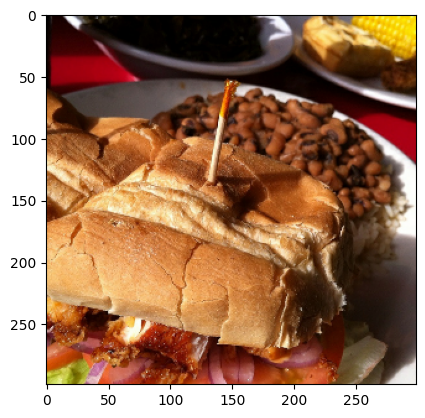

[lstm log] _output.shape (1, 24, 256) ;; encoder_output.shape (1, 256)
[lstm log] _output.shape (1, 24, 256) ;; encoder_output.shape (1, 256)


TypeError: tuple indices must be integers or slices, not tuple

In [38]:
vocab = vectorization.get_vocabulary()
index_lookup = dict(zip(range(len(vocab)), vocab))
max_decoded_sentence_length = SEQ_LENGTH - 1
valid_images = list(valid_data.keys())


def generate_caption():
    # Select a random image from the validation dataset
    sample_img = np.random.choice(valid_images)

    # Read the image from the disk
    sample_img = decode_and_resize("coco/" + "train2014/" + sample_img)
    img = sample_img.numpy().clip(0, 255).astype(np.uint8)
    plt.imshow(img)
    plt.show()

    # Pass the image to the CNN
    img = tf.expand_dims(sample_img, 0)
    img = caption_model.cnn_model(img)

    # Pass the image features to the Transformer encoder
    encoded_img = caption_model.encoder(img, training=False)

    # Generate the caption using the Transformer decoder
    decoded_caption = "<start> "
    for i in range(max_decoded_sentence_length):
        tokenized_caption = vectorization([decoded_caption])[:, :-1]
        mask = tf.math.not_equal(tokenized_caption, 0)
        predictions = caption_model.decoder(
            tokenized_caption, encoded_img, training=False, mask=mask
        )
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = index_lookup[sampled_token_index]
        if sampled_token == "<end>":
            break
        decoded_caption += " " + sampled_token

    decoded_caption = decoded_caption.replace("<start> ", "")
    decoded_caption = decoded_caption.replace(" <end>", "").strip()
    print("Predicted Caption: ", decoded_caption)


# Check predictions for a few samples
generate_caption()
generate_caption()
generate_caption()

## End Notes

We saw that the model starts to generate reasonable captions after a few epochs. To keep
this example easily runnable, we have trained it with a few constraints, like a minimal
number of attention heads. To improve the predictions, you can try changing these training
settings and find a good model for your use case.